## SYMA : RecSys Challenge 2022

Authors:

- Victor Simonin
- Alexandre Lemonnier
- Sarah Gutierez
- Alexandre Poignant

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime

# Loading data

In [2]:
candidates = pd.read_csv('data/candidate_items.csv')
candidates

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


In [3]:
items = pd.read_csv('data/item_features.csv')
items

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


In [4]:
train_purchases = pd.read_csv('data/train_purchases.csv', dtype={'session_id': str, 'item_id': str, 'date':object})
train_purchases

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


In [5]:
train_sessions = pd.read_csv('data/train_sessions.csv', dtype={'session_id': str, 'item_id': str, 'date':object})
train_sessions

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


In [6]:
test_leaderboard_sessions = pd.read_csv('data/test_leaderboard_sessions.csv')
test_leaderboard_sessions

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# Data analysis

Items are represented in a sparse format with the id of the feature and its value. We have no information on whether or not it is categorical or numerical, or the number of features.  
We want to explore them a little bit and find a compact representation.

First we want to know the coverage of each feature:

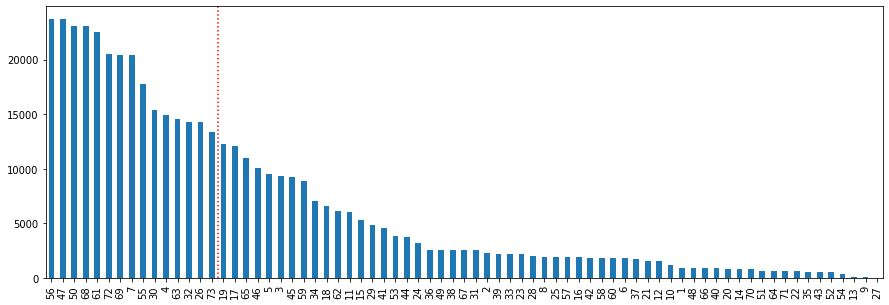

In [7]:
from matplotlib import pyplot as plt

coverage = items['feature_category_id'].sort_values(ascending=False).value_counts(sort=True)
coverage.plot(kind='bar', figsize=(15, 5))
plt.axvline(x = 14.5, color='r', linestyle='dotted')

73 features is not that much, let's see how each of them look. Display the counts / min / max / std for each feature.

In [8]:
items.drop(columns='item_id').groupby('feature_category_id', sort=False).describe()

feature_value_id                                        \
                               count        mean         std    min    25%   
feature_category_id                                                          
56                           23691.0  360.189861  107.438375    1.0  365.0   
62                            6148.0  639.005856  318.478435   15.0  801.0   
68                           23038.0  443.496050  230.800434   10.0  351.0   
33                            2221.0  328.501126  364.058791   36.0   36.0   
72                           20499.0  191.034392  218.286790    7.0   75.0   
...                              ...         ...         ...    ...    ...   
66                             877.0  869.124287   72.171785  264.0  886.0   
40                             877.0  594.037628  204.118748   49.0  449.0   
9                              137.0  223.635036   77.537171  175.0  175.0   
13                             137.0  580.554745  206.876701  252.0  252.0   
27                               1.0  423.000000         NaN  423.0  423.0   

                                          
                       50%    75%    max  
feature_category_id                       
56                   365.0  365.0  868.0  
62                   801.0  801.0  896.0  
68                   373.0  702.0  903.0  
33                    36.0  764.0  873.0  
72                    75.0  263.0  883.0  
...                    ...    ...    ...  
66                   886.0  886.0  886.0  
40                   717.0  717.0  717.0  
9                    190.0  190.0  369.0  
13                   698.0  698.0  905.0  
27                   423.0  423.0  423.0  

[73 rows x 8 columns]

We can see that the feature 27 is useless, because it has all the time the same value, we decided to remove it:

In [9]:
items.drop(items[items['feature_category_id'] == 27].index, inplace=True)

In [10]:
items

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


Let's see how the sessions are represented in the `train_sessions` dataset:

<AxesSubplot:>

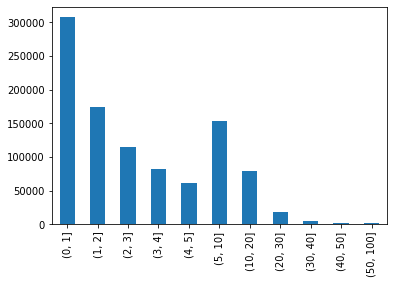

In [11]:
pd.cut(list(train_sessions['session_id'].value_counts()),
       bins=[0,1,2,3,4,5,10,20,30,40,50,100]).value_counts().plot(kind='bar')

We can see that most of the `train_sessions` dataset represent the session 0 and 1.

## Word2Vec embeddings

In [12]:
df_train = pd.concat([train_sessions, train_purchases])
sessions_grp = df_train.sort_values(by=['date']).groupby(['session_id'])
sessions = map(lambda x: x[1]['item_id'].values.tolist(), sessions_grp)

In [13]:
from sklearn.model_selection import train_test_split
test_item_ids=list(test_leaderboard_sessions['item_id'].unique())
vocab=list(sessions)
vocab.append(test_item_ids)
test_item_ids=list(test_leaderboard_sessions['item_id'].unique())
train_df, test_df = train_test_split(train_purchases, test_size=0.02)
train_df = train_sessions[train_sessions['session_id'].isin(list(train_df['session_id']))]

sessions_t_grp = list(train_df.sort_values(by=['date']).groupby(['session_id']))

sessions_train=list(map(lambda x: x[1]['item_id'].values.tolist(), sessions_t_grp))
sessions_train[:5]

[['26396', '5288', '3298'],
 ['15533', '15533', '15533'],
 ['2972', '2972', '2972', '2972', '2972', '3402'],
 ['4872'],
 ['9238', '25745']]

In [14]:
test_df.head()

,session_id,item_id,date
459260,2040853,19812,2021-03-01 10:54:16.24
320981,1426933,21850,2020-02-24 21:49:20.618
837149,3717298,25412,2020-12-10 14:09:55.332
48307,214441,594,2020-10-12 15:02:02.332
876933,3894474,25870,2021-04-13 12:03:41.756


In [15]:
from gensim.models.word2vec import Word2Vec 

In [16]:
model = Word2Vec(vocab, min_count= 1,
        epochs= 5,
        workers= 10,
        sg= 1,
        window= 4,
        seed=42,
        max_vocab_size=None)
        

model.train(sessions_train, total_examples=model.corpus_count, epochs=model.epochs, compute_loss=True)
embeddings = model.wv

In [17]:
test_sessions = list(test_leaderboard_sessions.sort_values(by=['date']).groupby(['session_id']))
test_sessions

[(26,
     session_id  item_id                     date
  0          26    19185  2021-06-16 09:53:54.158),
 (200,
     session_id  item_id                     date
  1         200    17089  2021-06-25 12:23:40.811
  2         200    17089  2021-06-25 12:24:36.631
  3         200     8060  2021-06-25 12:24:41.677
  4         200     4758  2021-06-25 12:24:50.692),
 (205,
     session_id  item_id                     date
  5         205     8194  2021-06-11 00:28:07.058),
 (495,
     session_id  item_id                     date
  6         495     6853  2021-06-14 22:13:06.741),
 (521,
     session_id  item_id                    date
  7         521    26471  2021-06-19 13:50:03.09),
 (587,
     session_id  item_id                    date
  8         587    22204  2021-06-01 16:43:22.80),
 (721,
     session_id  item_id                     date
  9         721    13914  2021-06-19 18:46:57.263),
 (810,
      session_id  item_id                     date
  10         810    11028  2021-06

In [18]:
results_fpath=f'data/recsys-dressipi.csv'
def predict_test_leaderboard_sessions(test_df, embeddings, topn=100):
    with open(results_fpath, "w") as results_file:
        results_file.write("session_id,item_id,rank\n")
        for _, df in tqdm(test_df):
            session_id=df.reset_index()['session_id'][0]
            query_item=list(df['item_id'])
            if len(query_item) == 1:
                query_item=query_item[0]
            neighbors = embeddings.similar_by_vector(query_item, topn=topn)
            recommendations = [item for item, score in neighbors]
            for rank, item_id in enumerate(recommendations):
                results_file.write(f"{session_id},{item_id},{rank+1}\n")

predict_test_leaderboard_sessions(test_sessions, embeddings)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:37<00:00, 513.49it/s]


The score here on the challenge is not great, we need to try different way to solve the problem.

# Part 2

In [19]:
train_sessions = pd.read_csv('data/train_sessions.csv')
train_purchases = pd.read_csv('data/train_purchases.csv')
test_sessions = pd.read_csv('data/test_final_sessions.csv')
test_leaderboard_sessions = pd.read_csv('data/test_leaderboard_sessions.csv')

In [20]:
train_sessions = train_sessions.append(train_purchases).reset_index(drop=True)
train_sessions = train_sessions.append(test_sessions).reset_index(drop=True)
train_sessions = train_sessions.append(test_leaderboard_sessions).reset_index(drop=True)

/tmp/ipykernel_3691/784385031.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_sessions = train_sessions.append(train_purchases).reset_index(drop=True)
/tmp/ipykernel_3691/784385031.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_sessions = train_sessions.append(test_sessions).reset_index(drop=True)
/tmp/ipykernel_3691/784385031.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_sessions = train_sessions.append(test_leaderboard_sessions).reset_index(drop=True)


In [21]:
def parse(x):
    if "." in x:
        date_time = datetime.strptime(x,"%Y-%m-%d %H:%M:%S.%f")
    else:
        date_time = datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
    return datetime.timestamp(date_time)

def make_user_time_tuple(group_df, user_col='session_id', item_col='item_id', time_col='ts'):
    user_time_tuples = list(zip(group_df[user_col], group_df[time_col]))
    return user_time_tuples


def make_item_time_tuple(group_df, user_col='session_id', item_col='item_id', time_col='ts'):
    # group_df = group_df.drop_duplicates(subset=[user_col, item_col], keep='last')
    item_time_tuples = list(zip(group_df[item_col], group_df[time_col]))
    return item_time_tuples
    
def get_user_item_time_dict(df, user_col='session_id', item_col='item_id', time_col='ts'):
    user_item_ = df.sort_values(by=[user_col, time_col])

    user_item_ = user_item_.groupby(user_col).apply(lambda group: make_item_time_tuple(group, user_col, item_col, time_col)).reset_index().rename(columns={0: 'item_id_time_list'})
    user_item_time_dict = dict(zip(user_item_[user_col], user_item_['item_id_time_list']))
    return user_item_time_dict


def get_item_user_time_dict(df, user_col='session_id', item_col='item_id', time_col='ts'):
    item_user_df = df.sort_values(by=[item_col, time_col])
    item_user_df = item_user_df.groupby(item_col).apply(lambda group: make_user_time_tuple(group, user_col, item_col, time_col)).reset_index().rename(columns={0: 'user_id_time_list'})
    item_user_time_dict = dict(zip(item_user_df[item_col], item_user_df['user_id_time_list']))
    return item_user_time_dict

In [22]:
ts_list = []
for time in tqdm(train_sessions['date']):
    ts_list.append(parse(time))
train_sessions['ts'] = ts_list
train_sessions=train_sessions.sort_values(by = ['session_id','ts'],ascending = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6199312/6199312 [00:33<00:00, 186856.07it/s]


In [ ]:
#Recall function
def get_sim2(df, user_col, item_col,alpha):
  user_item_ = df.groupby(user_col)[item_col].agg(lambda x: list(x)).reset_index()
  user_item_dict = dict(zip(user_item_[user_col], user_item_[item_col]))
  user_time_ = df.groupby(user_col)['ts'].agg(lambda x: list(x)).reset_index()  # 引入时间因素
  user_time_dict = dict(zip(user_time_[user_col], user_time_['ts']))

  sim_item = {}
  item_cnt = defaultdict(int)
  for user, items in tqdm(user_item_dict.items()):
    for loc1, item in enumerate(items):
      item_cnt[item] += 1
      sim_item.setdefault(item, {})
      for loc2, relate_item in enumerate(items):
        if item == relate_item:
          continue
        t1 = user_time_dict[user][loc1] #time
        t2 = user_time_dict[user][loc2] #time

        loc_alpha = 1.0 if loc2>loc1 else 0.7
        loc_weight = loc_alpha*(0.8**(abs(loc2-loc1)-1))
        time_weight = np.exp(-abs(t2 - t1)/259200)
     

        sim_item[item].setdefault(relate_item, 0)

        sim_item[item][relate_item] += loc_weight*time_weight/math.log(1+len(items))
  
  
  sim_item_corr = sim_item.copy()
  # for i, related_items in tqdm(sim_item.items()):
  #     for j, cij in related_items.items():
  #         sim_item_corr[i][j] = cij / math.sqrt(item_cnt[i] * item_cnt[j] * alpha) 


  return sim_item_corr,item_cnt

sim_item_corr,item_cnt = get_sim2(train_sessions, 'session_id','item_id',1)

In [2]:
test = [1, 2, 3, 4]
for i in tqdm(test):
    print(i)

  0%|          | 0/4 [00:00<?, ?it/s]

1
2
3
4
